In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, VGG19
# from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Reshape, Multiply, Flatten
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape, Multiply, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Define constants
train_data_dir = '/kaggle/input/fruits/Training/Training'
test_data_dir = '/kaggle/input/fruits/Test/Test'
img_width, img_height = 224, 224
batch_size = 32
num_epochs = 10
num_classes = 3 

In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1720 images belonging to 3 classes.
Found 576 images belonging to 3 classes.


In [5]:
# Define Squeeze-and-Excitation block
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

In [6]:
# Provide the path to the manually uploaded Xception weights file
weights_path = '/kaggle/input/xception-weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Xception model with manually uploaded weights
xception_base_model = Xception(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
xception_base_model.load_weights(weights_path)

x = squeeze_excite_block(xception_base_model.output)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
xception_predictions = Dense(num_classes, activation='softmax')(x)
xception_model = Model(inputs=xception_base_model.input, outputs=xception_predictions)

In [7]:
# CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))

In [8]:
# Provide the path to the manually uploaded VGG19 weights file
vgg19_weights_path = '/kaggle/input/vgg19-weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

# VGG19 model with manually uploaded weights
vgg19_base_model = VGG19(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
vgg19_base_model.load_weights(vgg19_weights_path)

vgg19_model = Sequential()
vgg19_model.add(vgg19_base_model)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(512, activation='relu'))
vgg19_model.add(Dense(num_classes, activation='softmax'))

In [9]:
# Custom SE-Net model
input_tensor = Input(shape=(img_width, img_height, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = squeeze_excite_block(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = squeeze_excite_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
se_net_predictions = Dense(num_classes, activation='softmax')(x)
se_net_model = Model(inputs=input_tensor, outputs=se_net_predictions)

In [10]:
# Compile the models
xception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg19_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
se_net_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:

# Train the models and collect history
xception_history = xception_model.fit(train_generator, epochs=num_epochs, validation_data=test_generator)


Epoch 1/10
54/54 [==============================] - 714s 13s/step - loss: 0.0835 - accuracy: 0.9779 - val_loss: 12.7737 - val_accuracy: 0.5556
Epoch 2/10
54/54 [==============================] - 699s 13s/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.5633 - val_accuracy: 0.9392
Epoch 3/10
54/54 [==============================] - 698s 13s/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 10.2430 - val_accuracy: 0.5729
Epoch 4/10
54/54 [==============================] - 728s 14s/step - loss: 8.0525e-05 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 5/10
54/54 [==============================] - 697s 13s/step - loss: 8.9904e-05 - accuracy: 1.0000 - val_loss: 5.1243e-07 - val_accuracy: 1.0000
Epoch 6/10
54/54 [==============================] - 697s 13s/step - loss: 1.0163e-06 - accuracy: 1.0000 - val_loss: 2.1110e-08 - val_accuracy: 1.0000
Epoch 7/10
54/54 [==============================] - 698s 13s/step - loss: 8.3899e-06 - accuracy: 1.0000 - val_loss: 8.2784e-10

In [12]:
cnn_history = cnn_model.fit(train_generator, epochs=num_epochs, validation_data=test_generator)



Epoch 1/10
54/54 [==============================] - 116s 2s/step - loss: 0.1813 - accuracy: 0.9512 - val_loss: 4.1659e-06 - val_accuracy: 1.0000
Epoch 2/10
54/54 [==============================] - 114s 2s/step - loss: 2.5165e-04 - accuracy: 1.0000 - val_loss: 3.1417e-07 - val_accuracy: 1.0000
Epoch 3/10
54/54 [==============================] - 115s 2s/step - loss: 4.8791e-05 - accuracy: 1.0000 - val_loss: 8.0508e-08 - val_accuracy: 1.0000
Epoch 4/10
54/54 [==============================] - 115s 2s/step - loss: 5.7326e-06 - accuracy: 1.0000 - val_loss: 3.3942e-08 - val_accuracy: 1.0000
Epoch 5/10
54/54 [==============================] - 115s 2s/step - loss: 2.3394e-06 - accuracy: 1.0000 - val_loss: 3.0009e-08 - val_accuracy: 1.0000
Epoch 6/10
54/54 [==============================] - 115s 2s/step - loss: 1.8089e-06 - accuracy: 1.0000 - val_loss: 2.8147e-08 - val_accuracy: 1.0000
Epoch 7/10
54/54 [==============================] - 115s 2s/step - loss: 2.1178e-06 - accuracy: 1.0000 - val_l

In [13]:
vgg19_history = vgg19_model.fit(train_generator, epochs=num_epochs, validation_data=test_generator)


Epoch 1/10
54/54 [==============================] - 1957s 36s/step - loss: 3.8008 - accuracy: 0.3762 - val_loss: 1.0900 - val_accuracy: 0.4271
Epoch 2/10
54/54 [==============================] - 1989s 37s/step - loss: 1.7831 - accuracy: 0.4907 - val_loss: 1.0479 - val_accuracy: 0.4271
Epoch 3/10
54/54 [==============================] - 1959s 36s/step - loss: 0.9249 - accuracy: 0.5308 - val_loss: 0.4840 - val_accuracy: 0.7153
Epoch 4/10
54/54 [==============================] - 1960s 36s/step - loss: 1.2726 - accuracy: 0.4779 - val_loss: 1.0869 - val_accuracy: 0.4271
Epoch 5/10
54/54 [==============================] - 1959s 36s/step - loss: 1.0834 - accuracy: 0.4291 - val_loss: 1.0796 - val_accuracy: 0.4271
Epoch 6/10
54/54 [==============================] - 1965s 36s/step - loss: 1.0841 - accuracy: 0.4250 - val_loss: 1.0815 - val_accuracy: 0.4271
Epoch 7/10
54/54 [==============================] - 1964s 36s/step - loss: 1.0852 - accuracy: 0.4291 - val_loss: 1.0835 - val_accuracy: 0.4271

In [14]:
se_net_history = se_net_model.fit(train_generator, epochs=num_epochs, validation_data=test_generator)

Epoch 1/10
54/54 [==============================] - 213s 4s/step - loss: 0.8565 - accuracy: 0.6558 - val_loss: 0.4637 - val_accuracy: 1.0000
Epoch 2/10
54/54 [==============================] - 212s 4s/step - loss: 0.3677 - accuracy: 0.8378 - val_loss: 0.1311 - val_accuracy: 1.0000
Epoch 3/10
54/54 [==============================] - 212s 4s/step - loss: 0.1669 - accuracy: 0.9349 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 4/10
54/54 [==============================] - 212s 4s/step - loss: 0.0745 - accuracy: 0.9756 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 5/10
54/54 [==============================] - 212s 4s/step - loss: 0.0395 - accuracy: 0.9849 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 6/10
54/54 [==============================] - 213s 4s/step - loss: 0.0218 - accuracy: 0.9930 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/10
54/54 [==============================] - 212s 4s/step - loss: 0.0175 - accuracy: 0.9936 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/10
54

In [15]:

# Evaluate the models
xception_eval = xception_model.evaluate(test_generator)
cnn_eval = cnn_model.evaluate(test_generator)
vgg19_eval = vgg19_model.evaluate(test_generator)
se_net_eval = se_net_model.evaluate(test_generator)

print("Xception Model Evaluation:", xception_eval)
print("CNN Model Evaluation:", cnn_eval)
print("VGG19 Model Evaluation:", vgg19_eval)
print("SE-Net Model Evaluation:", se_net_eval)

18/18 [==============================] - 16s 896ms/step - loss: 1.4804e-04 - accuracy: 1.0000
Xception Model Evaluation: [0.0, 1.0]
CNN Model Evaluation: [1.7798607032659675e-08, 1.0]
VGG19 Model Evaluation: [1.0797126293182373, 0.4270833432674408]
SE-Net Model Evaluation: [0.00014804006787016988, 1.0]


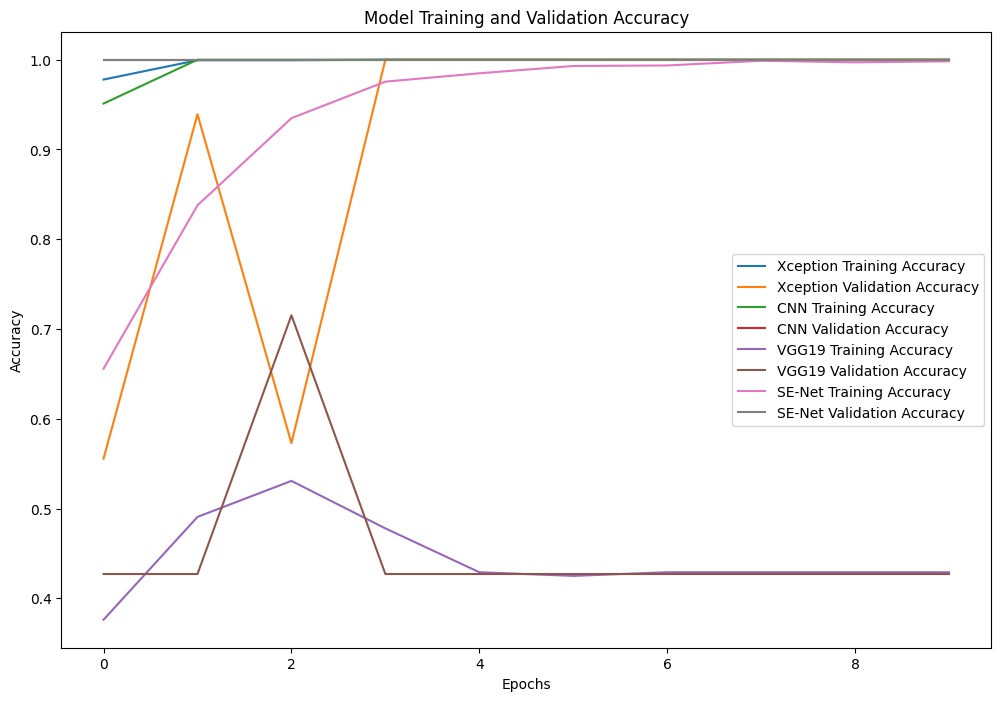

In [16]:
import matplotlib.pyplot as plt


# Plotting accuracy
plt.figure(figsize=(12, 8))
plt.plot(xception_history.history['accuracy'], label='Xception Training Accuracy')
plt.plot(xception_history.history['val_accuracy'], label='Xception Validation Accuracy')

plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')

plt.plot(vgg19_history.history['accuracy'], label='VGG19 Training Accuracy')
plt.plot(vgg19_history.history['val_accuracy'], label='VGG19 Validation Accuracy')

plt.plot(se_net_history.history['accuracy'], label='SE-Net Training Accuracy')
plt.plot(se_net_history.history['val_accuracy'], label='SE-Net Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.legend()
plt.show()



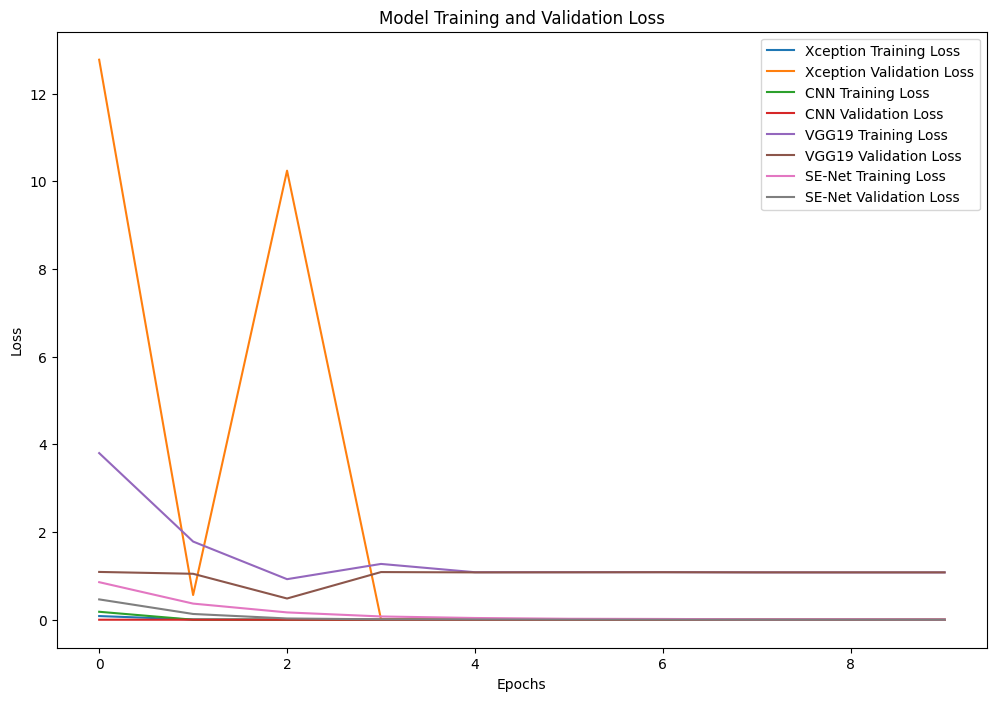

In [17]:
# Plotting loss
plt.figure(figsize=(12, 8))
plt.plot(xception_history.history['loss'], label='Xception Training Loss')
plt.plot(xception_history.history['val_loss'], label='Xception Validation Loss')

plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')

plt.plot(vgg19_history.history['loss'], label='VGG19 Training Loss')
plt.plot(vgg19_history.history['val_loss'], label='VGG19 Validation Loss')

plt.plot(se_net_history.history['loss'], label='SE-Net Training Loss')
plt.plot(se_net_history.history['val_loss'], label='SE-Net Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training and Validation Loss')
plt.legend()
plt.show()
